In [1]:
import os
import time
import tqdm
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, FancyArrowPatch
from matplotlib import colors
import logging
import yaml
import json
import joblib
from sklearn.impute import SimpleImputer
from scipy.stats.contingency import crosstab
import networkx as nx
from matplotlib.lines import Line2D
import umap
import itertools
import scipy
from scipy.cluster.hierarchy import linkage, dendrogram
import seaborn as sns

sys.path.append(os.getcwd())
from functions.load_model import load_tolist
import functions.visualise as vis
import functions.process as proc
from functions.io import setup_logger, makedir
from functions import FeatureEngine
from numba import jit

from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests

/gpfs/soma_fs/home/boeger/usr/miniconda3/envs/sklearn-env2/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/gpfs/soma_fs/home/boeger/usr/miniconda3/envs/sklearn-env2/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/gpfs/soma_fs/home/boege

In [2]:
def load_data_from_keys(json_file, key):
    def traverse_dict(d, key):
        if isinstance(d, dict):
            if key in d.keys():
                return {key: d[key]}
            else:
                return {k: traverse_dict(v, key) for k, v in d.items()}
        elif isinstance(d, list):
            return [traverse_dict(x, key) for x in d]
        else:
            return d

    with open(json_file, 'r') as f:
        data = json.load(f)
    nested_dict = traverse_dict(data, key)
    return {(innerKey, outerKey): values for outerKey, innerDict in nested_dict.items() for innerKey, values in innerDict.items()} 

In [3]:
def sig_stars(p):
    if p <= .01:
        return int(-np.ceil(np.log10(abs(p)))) # should be correct needs checking
    elif p <= .05:
        return 1
    else:
        return 0

Please provide where your files are stored and where you would like your data to be saved in the following section.

In [4]:
datestr = time.strftime("%Y%m%d-%Hh%Mm")
inpath = "/gpfs/soma_fs/home/boeger/PpaPred/data_eren" 
#inpath = '/gpfs/soma_fs/scratch/src/boeger/data_roca'

outpath = "/gpfs/soma_fs/home/boeger/PpaPred/data_eren"

config_path = "config.yml"
include, fig = ['Exp1_WT_larvae', 'Exp1_WT_OP50'], 'Fig1'
file_pattern = 'batch.json'
inpath_with_subfolders = True

WT_ordering = False#[1., 0., 2., 6., 8., 3., 4., 7., 5.]
plot = False

In [5]:
#all_transitions = None
#all_durations = None

### I/O ################################################
all_files = [os.path.join(root, name) for root, dirs, files in os.walk(inpath) for name in files if file_pattern in name and any([c in name for c in include])]
all_files.sort(key = lambda i: np.where([c in i for c in include])) # to sort all_files as given in include
loc_all = {os.path.basename(f):f for f in all_files}

if outpath is None:
    outpath = os.path.commonpath(all_files)
    
### Configuration ################################################
config = yaml.safe_load(open(config_path, "r"))
cluster_color = config['cluster_color']
cluster_group = config['cluster_group_man']
cluster_label = config['cluster_names']
clu_group_label = {_:f'{_}, {__}' for _, __ in tuple(zip([c for c in cluster_label.values()],[g for g in cluster_group.values()]))}
skip_already = config['settings']['skip_already']
fps = 30
loc_all

{'Exp1_WT_larvae_batch.json': '/gpfs/soma_fs/home/boeger/PpaPred/data_eren/Exp1_WT_larvae_batch.json',
 'Exp1_WT_OP50_batch.json': '/gpfs/soma_fs/home/boeger/PpaPred/data_eren/Exp1_WT_OP50_batch.json'}

In [6]:
import numpy as np
import pandas as pd
test = pd.DataFrame([[0,1,2,np.nan, np.nan, 5,6,9],[999,999,999,999,np.nan, np.nan,999,999],[0,10,20,10, np.nan, 50,60,90]]).T
interp = pd.DataFrame([])
for c in test.columns:
    interp[c] = test[c].interpolate()
test, interp

(     0      1     2
 0  0.0  999.0   0.0
 1  1.0  999.0  10.0
 2  2.0  999.0  20.0
 3  NaN  999.0  10.0
 4  NaN    NaN   NaN
 5  5.0    NaN  50.0
 6  6.0  999.0  60.0
 7  9.0  999.0  90.0,
      0      1     2
 0  0.0  999.0   0.0
 1  1.0  999.0  10.0
 2  2.0  999.0  20.0
 3  3.0  999.0  10.0
 4  4.0  999.0  30.0
 5  5.0  999.0  50.0
 6  6.0  999.0  60.0
 7  9.0  999.0  90.0)

[7, 5, 2, 3, 6, 4, 0, 1]

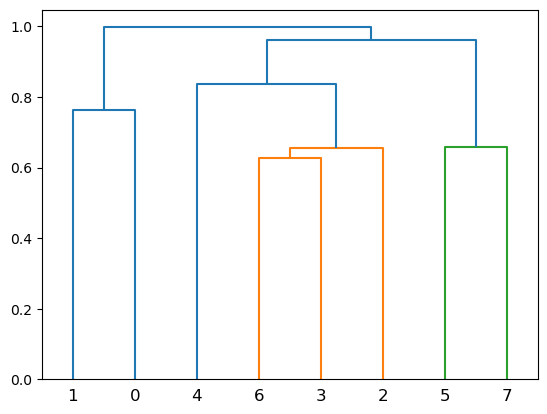

In [47]:
dendrogram(Z)['leaves'][::-1]

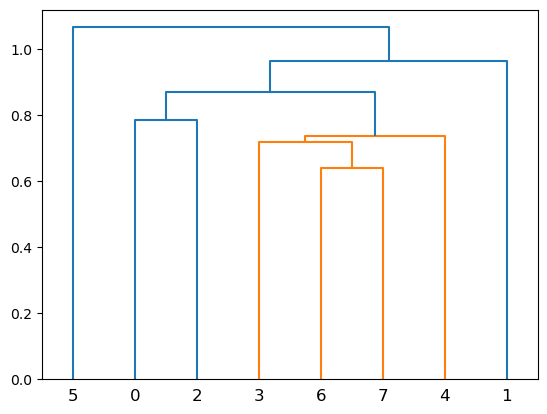

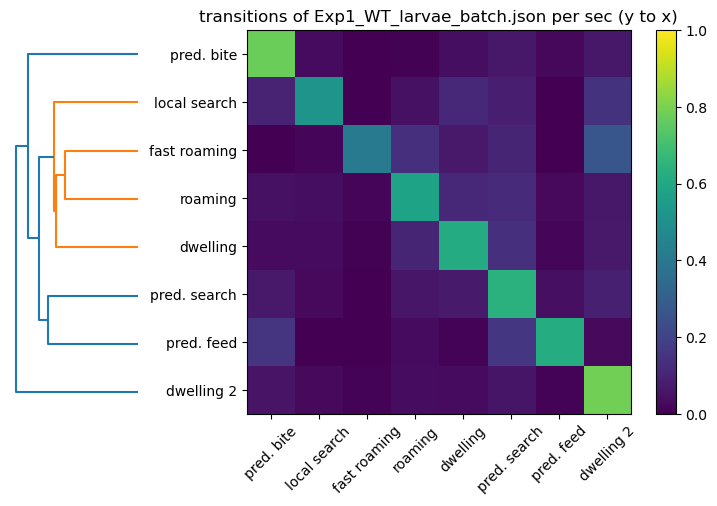

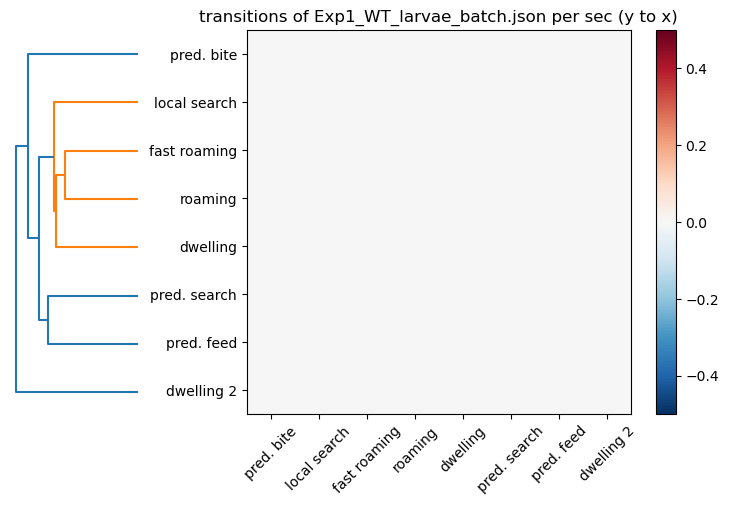

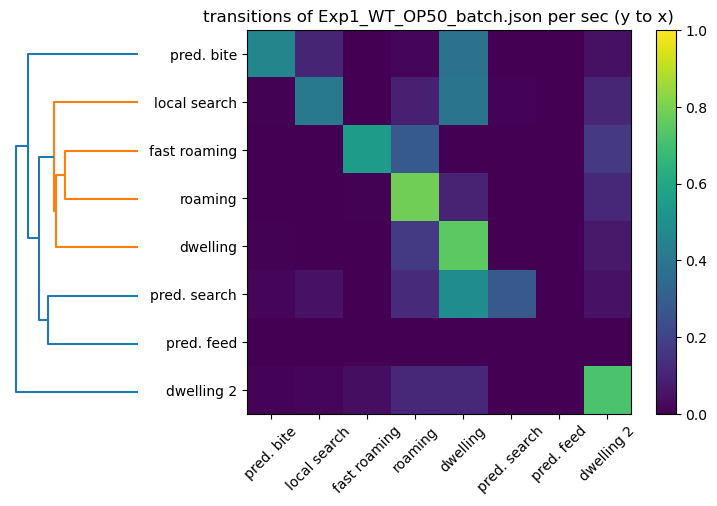

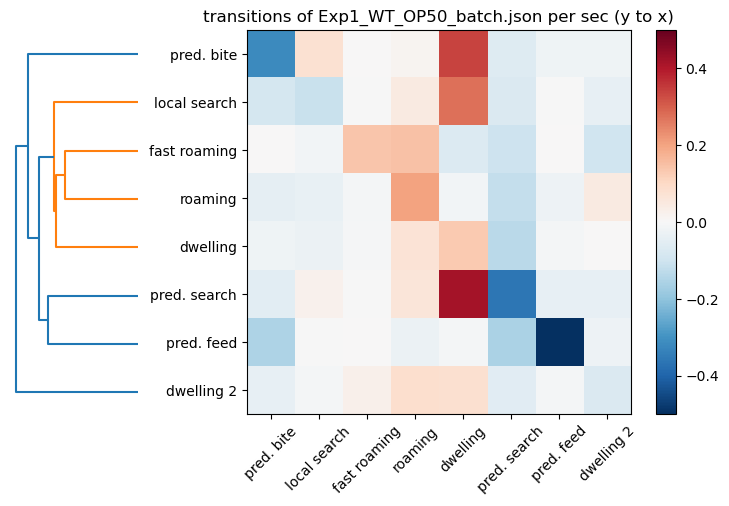

In [49]:
for metric in ['mean transitions']:
    outmetric = os.path.join(outpath, f"{datestr}_{''.join(metric.split(' '))}_Utest")
    
    metric_multi = None
    for fn, fpath in loc_all.items():
        batch_metric = pd.DataFrame(load_data_from_keys(fpath, metric)).droplevel(0, axis=1)
        batch_metric.columns = pd.MultiIndex.from_product([[fn], batch_metric.columns])
        if metric_multi is None:
            metric_multi = batch_metric
        else:
            metric_multi = pd.concat([metric_multi, batch_metric], axis=1)
        #batch_etho = load_data_from_keys(fpath, 'ethogram')
    if metric == 'mean duration':
        metric_multi = metric_multi/fps
    metric_multi.index.name = 'cluster'
    
    all_conds = metric_multi.columns.get_level_values(0).unique()
    id_cond = [c.split('_')[0] for c in all_conds]
    metric_multi.index = pd.MultiIndex.from_tuples([eval(i) for i in metric_multi.index])
    metric_multi = metric_multi.drop(-1, level = 0)
    metric_multi = metric_multi.drop(-1, level = 1)
    
    tr_larvae = metric_multi['Exp1_WT_larvae_batch.json'].mean(axis=1).unstack(level=0)
    tr_larvae_norm = (tr_larvae/tr_larvae.sum(axis=0)).fillna(0)#.T # transposed so that transitions from y to x
    p_dist_tr = scipy.spatial.distance.pdist(tr_larvae_norm)
    Z = linkage(p_dist_tr, 'complete', optimal_ordering=True)#ward #complete
    # extract closest cluster
    ordering = dendrogram(Z)['leaves'][::-1]
    #ordering = np.concatenate((Z[::-1,0],Z[:,1]))
    #ordering = ordering[[o in list(tr_larvae_norm.index) for o in ordering]]
    tr_larvae_norm = tr_larvae_norm.iloc[ordering,ordering]
    
    all_trans = {}
    for i, cond in enumerate(all_conds):
        fr_transition = metric_multi[cond].mean(axis=1).unstack(level=0)
        fr_transition_norm = (fr_transition/fr_transition.sum(axis=0)).fillna(0).iloc[ordering,ordering]#.T # transposed so that transitions from y to x
        all_trans[cond] = fr_transition
        
        #####
        def transplot(fr_transition_norm, ordering, cmap='viridis', vmin=0, vmax=1, dendro = None):
            fig = plt.figure()
            
            if dendrogram is not None:
                axs1 = fig.add_axes([0, .895, .2, .805])
                axs1.axis('off')
                dn = dendrogram(dendro, orientation='left',ax= axs1)
                
            axs2 = fig.add_axes([0.33, .9, .8, .8])    
            im = axs2.imshow(fr_transition_norm.T, cmap =cmap, vmin=vmin, vmax=vmax) # transposed so that transitions from y to x
            axs2.set_xticks(range(len(ordering)))
            axs2.set_xticklabels([cluster_group[k] for k in ordering], rotation=45,ha="center")
            axs2.set_yticks(range(len(ordering)))
            axs2.set_yticklabels([cluster_group[k] for k in ordering])
            cbar = axs2.figure.colorbar(im, ax=axs2)
            #cbar.ax.set_ylabel("X^0.4 normalization", rotation=90, labelpad= 6)
            axs2.set_title(f"transitions of {cond} per sec (y to x)")
            plt.show()
            return fig

        transplot_cond = transplot(fr_transition_norm, ordering, dendro = Z)
        #####
        
        
        trans_rel = fr_transition_norm-tr_larvae_norm
        transplot_diff = transplot(trans_rel, ordering,  cmap='RdBu_r',vmin=-.5,vmax=.5, dendro = Z)

None


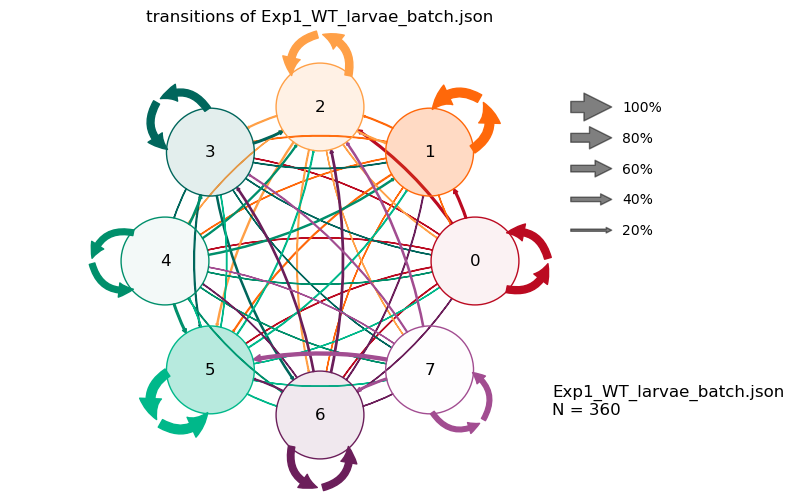

None


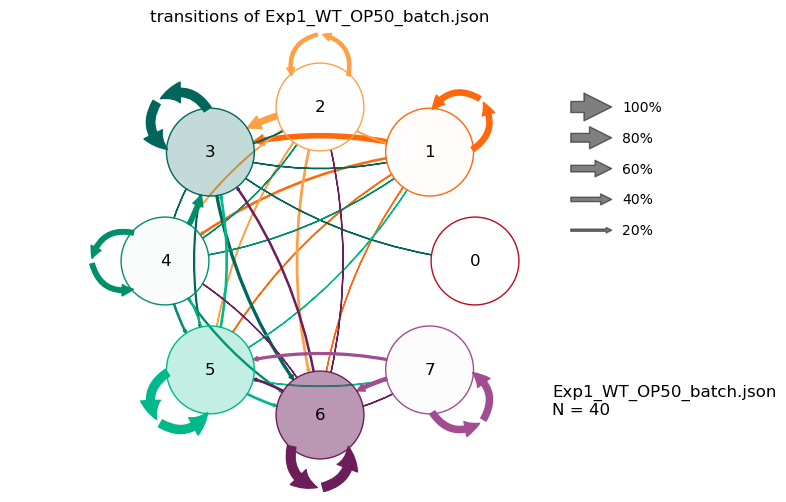

In [50]:
for metric in ['rel time in']:
    outmetric = os.path.join(outpath, f"{datestr}_{''.join(metric.split(' '))}_Utest")
    
    metric_multi = None
    for fn, fpath in loc_all.items():
        batch_metric = pd.DataFrame(load_data_from_keys(fpath, metric)).droplevel(0, axis=1)
        batch_metric.columns = pd.MultiIndex.from_product([[fn], batch_metric.columns])
        if metric_multi is None:
            metric_multi = batch_metric
        else:
            metric_multi = pd.concat([metric_multi, batch_metric], axis=1)
        #batch_etho = load_data_from_keys(fpath, 'ethogram')
    metric_multi.index.name = 'cluster'
    
    for i, cond in enumerate(all_conds):
        mean_metric = metric_multi[cond].mean(axis=1)
        trans_ = all_trans[cond]/all_trans[cond].sum(axis=0).fillna(0)
        transition_plot = vis.transition_plotter(trans_.values.copy(), cluster_color, node_alpha=mean_metric)
        plt.text(1.5, -1, f'{cond}\nN = {len(metric_multi[cond].T)}', fontsize=12)
        plt.title(f"transitions of {cond}")
        plt.show()
        

In [28]:
import scipy
p_dist_tr = scipy.spatial.distance.pdist(tr_larvae_norm)
Z = linkage(p_dist_tr, 'complete', optimal_ordering=True)
Z

array([[ 3.        ,  4.        ,  0.64041504,  2.        ],
       [ 2.        ,  8.        ,  0.71961399,  3.        ],
       [ 9.        ,  5.        ,  0.73674233,  4.        ],
       [ 1.        ,  6.        ,  0.78512189,  2.        ],
       [11.        , 10.        ,  0.8704546 ,  6.        ],
       [12.        ,  7.        ,  0.96373461,  7.        ],
       [ 0.        , 13.        ,  1.06658495,  8.        ]])

In [26]:
p_dist_tr

array([1.02724539, 0.95658239, 0.9330499 , 0.81262756, 0.8874731 ,
       0.94494863, 1.06658495, 0.8704546 , 0.8310953 , 0.74370218,
       0.80385058, 0.78512189, 0.89065483, 0.7041301 , 0.71961399,
       0.71981323, 0.75759239, 0.95924633, 0.64041504, 0.73674233,
       0.75764092, 0.96373461, 0.65042279, 0.75294565, 0.90062547,
       0.78620534, 0.87223218, 0.93130506])

In [29]:
ordering

array([5., 0., 3., 6., 7., 4., 2., 1.])

[5, 0, 2, 3, 6, 7, 4, 1]

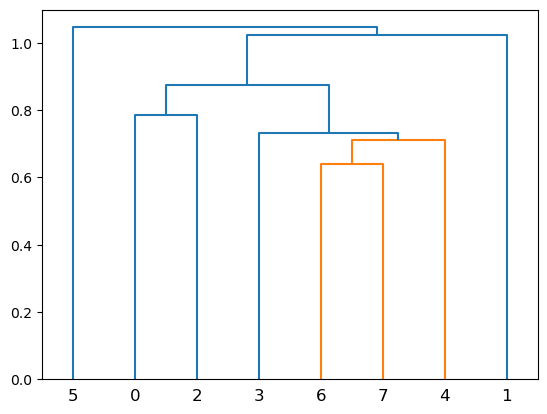

In [8]:
dendrogram(Z)['leaves']

In [474]:
stats_json = {'meta':{'metric': metric,
                          'statistical test': 'Mann-Whitney-U-Test, two-sided',
                          'bonferroni correction': 'statsmodels...multipletests',
                          'population': stat_pop},
              'adjusted ps': all_ps.to_dict(),
              'Mann-Whitney U': all_U1s.to_dict(),
              'unadjusted ps': all_ps_orig.to_dict(),
              }
jsnF = json.dumps(stats_json, indent = 4)
with open(os.path.join(outpath, f'{datestr}_{metric}_Utest.json'), "w") as outfile:
    outfile.write(jsnF)

In [595]:
li = [eval(i) for i in metric_multi.index]
type(li[0])

tuple

In [453]:
op.itemgetter('metric', 'statistical test', 'bonferroni correction', 'population')(stats_json)
op.getitem(stats_json,'metric')

'mean duration'

In [93]:
from scipy import stats
U1s, pvs = stats.mannwhitneyu(metric_multi[stat_pop], metric_multi['bac_data_batch.json'], axis=1, nan_policy='omit')

In [103]:

___,ps_adjusted,__,_ = multipletests(pvs, method='bonferroni')
np.round(ps_adjusted,5)

array([1.     , 0.00474, 1.     ,     nan, 0.00315, 0.70921, 0.74902,
       0.     , 0.14899])

In [ ]:


    ### Load data ################################################
    #data_batch = load_tolist(fpath, droplabelcol=False)
    #data_batch_concat = pd.concat([d for d in data_batch], axis=0)
    
    #y_batch_concat = data_batch_concat['prediction']
    #y_batch = [d['prediction'] for d in data_batch]

    
    ### Batch summary ############################################
    for i,d in enumerate(loc_summ):
        summ_ = pd.read_csv(d)
        dev_ = (~summ_.isna()).astype(int)
        summ_ = summ_.fillna(0)
        #trans_col_ = [[c for c in fr_transition_],[c for c in fr_transition_]]
        
        if i == 0:
            summ = summ_
            devider = dev_
        else:
            summ += summ_
            devider += dev_
    summary = summ/devider
    #summary.to_csv(os.path.join(outpath, f'{data_str}_batch_summary.csv'))
    
    total_dur = summary.duration_mean*summary.duration_count
    total_dur_rel = total_dur/total_dur.sum()
    
    ### Batch transitions ############################################
    #batch_transitions = np.full((len(loc_trans),9,9), np.nan) # with shape recordings,cluster from, cluster to        
    for i,d in enumerate(loc_trans):
        fr_transition_ = pd.read_csv(d, index_col=0)
        #batch_transitions[i] = fr_transition_
        trans_col_ = [[c for c in fr_transition_],[c for c in fr_transition_]]
        if i == 0:
            fr_transition = fr_transition_
            trans_col = trans_col_
        elif trans_col_ == trans_col:
            #print('this')
            fr_transition += fr_transition_
        else:
            print('WARNING')

    # merge all transitions across animals and experiments
    #if all_transitions is None:
    #    all_transitions = np.array([batch_transitions])
    #else:
    #    all_transitions,batch_transitions = padtoequalsize(all_transitions, batch_transitions, [-3])
    #     all_transitions = np.concatenate([all_transitions,[batch_transitions]],axis=0)

    # calculate the normalised transition and cluster
    # cluster behaviors with single linkage
    Z = linkage(fr_transition, 'single', optimal_ordering=True)
    # extract closest cluster
    ordering = np.concatenate((Z[::-1,0],Z[:,1]))
    ordering = ordering[ordering<len(cluster_label)]-1
    # calculate normalised transitions
    fr_trans_norm = (fr_transition/fr_transition.sum(axis=0)).fillna(0)
    fr_transition_clust = fr_trans_norm.iloc[ordering,ordering]
    fr_trans_norm.to_csv(os.path.join(outpath, f'{data_str}_batch_transitions_2.csv'), index=False)
    



    ### Batch durations ############################################
    #batch_durations = None
    for rec in loc_onoff:
        with open(rec,'r') as jf:
            onoff = json.load(jf)
        #duration = pd.DataFrame(dtype='float64')
        for cluster in onoff: #for bout in cluster
            cluster_dur = []
            for bout in onoff[cluster]: #for bout in cluster
                cluster_dur.append(bout[1])
            #duration = pd.concat([duration,pd.DataFrame([cluster_dur],index=[eval(cluster)],dtype='float64')],axis=0)
            
        cl_present = duration.index
        cl_range = range(min(cl_present), max(cl_present)+1)
        duration = duration.reindex(cl_range)
        
        if batch_durations is None:
            batch_durations = np.array([duration.values])
        else:
            batch_durations, duration = padtoequalsize(batch_durations, duration, [-1,-2])
            batch_durations = np.concatenate([batch_durations,[duration]],axis=0)
    
    if all_durations is None:
        all_durations = np.array([batch_durations])
    else:
        all_durations,batch_durations = padtoequalsize(all_durations, batch_durations, [-1,-2,-3])
        all_durations = np.concatenate([all_durations,[batch_durations]],axis=0)
    
        
    #############
    ### plots ###
    #############
    
    if plot:
        """
        transition_plot = vis.transition_plotter(fr_trans_norm.values, cluster_color, node_alpha=summary['duration_relative'].fillna(0).tolist())
        plt.text(1.5, -1, f'{data_str}\nN = {len(loc_trans)}', fontsize=12)
        plt.title(f"transitions of {data_str}")
        plt.savefig(os.path.join(outpath, f'{data_str}_batch_transitions.pdf'))
        plt.show()"""
        
        fig = plt.figure()
        axs1 = fig.add_axes([0, .895, .2, .805])
        axs1.axis('off')
        dn = dendrogram(Z, orientation='left',ax= axs1)
        axs2 = fig.add_axes([0.33, .9, .8, .8])
        im = axs2.imshow(fr_transition_clust,norm=colors.PowerNorm(.4,vmax=1))#vmin=0,vmax=.2)#
        axs2.set_xticks(range(len(cluster_group)))
        axs2.set_xticklabels([cluster_group[k] for k in ordering], rotation=45,ha="center")
        axs2.set_yticks(range(len(cluster_group)))
        axs2.set_yticklabels([cluster_group[k] for k in ordering])
        cbar = axs2.figure.colorbar(im, ax=axs2)
        cbar.ax.set_ylabel("X^0.4 normalization", rotation=90, labelpad= 6)
        axs2.set_title(f"transitions of {data_str} per sec (x to y)")
        plt.savefig(os.path.join(outpath, f'{data_str}_batch_transitheatmap_clust.pdf'),bbox_inches = "tight")
        plt.show()
    
        if WT_ordering:
            fr_transition_WT = fr_trans_norm.iloc[WT_ordering,WT_ordering]
            fig = plt.figure()
            axs1 = fig.add_axes([0, .895, .2, .805])
            axs1.axis('off')
            #dn = dendrogram(Z, orientation='left',ax= axs1)
            axs2 = fig.add_axes([0.33, .9, .8, .8])
            im = axs2.imshow(fr_transition_WT,norm=colors.PowerNorm(.4,vmax=1))#vmin=0,vmax=.2)#
            axs2.set_xticks(range(len(cluster_group)))
            axs2.set_xticklabels([cluster_group[k] for k in WT_ordering], rotation=45,ha="center")
            axs2.set_yticks(range(len(cluster_group)))
            axs2.set_yticklabels([cluster_group[k] for k in WT_ordering])
            cbar = axs2.figure.colorbar(im, ax=axs2)
            cbar.ax.set_ylabel("X^0.4 normalization", rotation=90, labelpad= 6)
            axs2.set_title(f"transitions of {data_str} per sec (x to y)")
            plt.savefig(os.path.join(outpath, f'{data_str}_batch_transitheatmap_WTclust.pdf'),bbox_inches = "tight")
            plt.show()
        
    
        
        fig, ax = plt.subplots(figsize=(2,5))
        b = ax.barh(range(len(total_dur_rel)),total_dur_rel, color=list(cluster_color.values())[1:])
        ax.set_yticks(range(len(cluster_group)-1))
        ax.set_yticklabels([cluster_group[k] for k in cluster_group][1:])
        ax.bar_label(b, label_type='edge', fmt='%.2g', padding=3)
        ax.invert_yaxis()
        plt.xlabel(f"total rel. duration")
        plt.title(data_str)
        plt.xlim(0,.6)
        plt.savefig(os.path.join(outpath, f'{data_str}_batch_totaldur.pdf'),bbox_inches = "tight")
        plt.show()
    
        # Calculate onoff sets
        onoff = proc.onoff_dict(y_batch, labels =np.unique(y_batch_concat))
    
        fig = plt.figure(figsize=(.6*len(onoff.keys()),3), layout='constrained')
        for k in onoff.keys():
            if not np.isnan(k):
                durs = pd.DataFrame(onoff[k])[1]/30
                plt.boxplot(durs, positions=[k], widths=.5,sym='', patch_artist = True, boxprops={'facecolor':cluster_color[k]},medianprops={'color':'k'})
        plt.xticks(range(len(cluster_group)-1),[cluster_group[k] for k in cluster_group][1:], rotation=45)
        plt.ylabel("sec")
        plt.ylim(0,30)
        plt.title(f"duration of {data_str} (without fliers)")
        plt.savefig(os.path.join(outpath, f'{data_str}_batch_durboxplot.pdf'),bbox_inches = "tight")
        plt.show()

In [44]:
all_durations.shape

(1, 40, 9, 62)

In [29]:
cl_present

Index(['-1', '0', '1', '2', '5'], dtype='object')

In [6]:
def df_withnans_alignright(df_):
    df = df_.copy()
    for i in range(len(df.columns)):
        nulls = df.iloc[np.where(df.iloc[:,i].notnull())[0][-1]+1:,i]
        notnulls = df.iloc[:np.where(df.iloc[:,i].notnull())[0][-1],i]
        right_aligned = pd.concat([nulls,notnulls], axis=0).reset_index(drop=True)
        df.iloc[:,i] = right_aligned
    return df

In [ ]:
np.random.seed(96)
bout_all = pd.DataFrame([])
bout_pre_all = pd.DataFrame([])
y_pre_all = pd.DataFrame([])
bout_post_all = pd.DataFrame([])
y_post_all = pd.DataFrame([])
feat = 'velocity'
cl = 1
rdm_subset = np.random.choice(len(onoff[cl]), 100, replace=False)
rdm_ons =[]
for i,oo in enumerate(rdm_subset):
    rdm_ons.append(onoff[cl][oo][0])
    onset = onoff[cl][oo][0]
    offset = onoff[cl][oo][0]+onoff[cl][oo][1]
    bout = data_batch_concat.reset_index(drop=True)[onset:offset].reset_index(drop=True)
    if all(bout[feat].isnull()):
        print(i)
        continue
    bout_pre = data_batch_concat.reset_index(drop=True)[onset-60:onset].reset_index(drop=True)
    bout_post = data_batch_concat.reset_index(drop=True)[offset:offset+60].reset_index(drop=True)
    
    bout_all = pd.concat([bout_all,bout[feat]], axis=1)

    bout_pre_all = pd.concat([bout_pre_all,bout_pre[feat]], axis=1)
    y_pre_all = pd.concat([y_pre_all,bout_pre['prediction']], axis=1)
    bout_post_all = pd.concat([bout_post_all,bout_post[feat]], axis=1)
    y_post_all = pd.concat([y_post_all,bout_post['prediction']], axis=1)

bout_all.columns = list(range(len(bout_all.columns)))
bout_pre_all.columns = list(range(len(bout_pre_all.columns)))
y_pre_all.columns = list(range(len(y_pre_all.columns)))
y_pre_color = y_pre_all[:150].replace(cluster_color)
bout_post_all.columns = list(range(len(bout_post_all.columns)))
y_post_all.columns = list(range(len(y_post_all.columns)))
y_post_color = y_post_all[:150].replace(cluster_color)

bout_all_right = df_withnans_alignright(bout_all)

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
mask = data_batch_concat.prediction.isin([7])
#fig = px.lines(bout_all, color = y_bout_all, width=800, height=400)
fig = make_subplots(rows=1, cols=2)
for trace in bout_all:
    bout_ = bout_all[trace].iloc[:90].dropna().reset_index(drop=True)
    bout_r_ = bout_all_right[trace].iloc[-90:].dropna().reset_index(drop=True)
    pre_ = bout_pre_all[trace][y_pre_all[trace]==y_pre_all[trace].iloc[-1]].reset_index(drop=True)
    post_ = bout_post_all[trace][y_post_all[trace]==y_post_all[trace].iloc[-1]].reset_index(drop=True)
    
    fig.add_trace(go.Scatter(x=np.arange(len(bout_)), y=bout_, line=dict(color=cluster_color[cl]),mode='lines'),
                 row=1, col=1)
    fig.add_trace(go.Scatter(x=np.arange(-len(pre_),0), y=pre_, line=dict(color=y_pre_color[trace].iloc[-1]),mode='lines'),
                 row=1, col=1)
    fig.add_trace(go.Scatter(x=np.arange(-len(bout_r_),0), y=bout_r_, line=dict(color=cluster_color[cl]),mode='lines'),
                 row=1, col=2)
    fig.add_trace(go.Scatter(x=np.arange(len(post_)), y=post_, line=dict(color=y_post_color[trace].iloc[-1]),mode='lines'),
                 row=1, col=2)

    
mean_ = pd.concat([bout_pre_all,bout_all],axis=0).reset_index(drop=True).mean(axis=1).iloc[:150]
mean_r_ = pd.concat([bout_all_right, bout_post_all],axis=0).reset_index(drop=True).mean(axis=1).iloc[-150:]
fig.add_trace(go.Scatter(x=np.arange(-60,90), y=mean_, line=dict(color='black',width=3),mode='lines'),
                 row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(-90,60), y=mean_r_, line=dict(color='black',width=3),mode='lines'),
                 row=1, col=2)

fig.add_vline(x=0, line=dict(color="Grey",width=5))
fig.update_xaxes(dtick=15, title=dict(text='Time [frames]'))
fig.update_yaxes(range=[0, max(bout_all.max().max(),bout_pre_all.max().max(),bout_post_all.max().max())],title=dict(text=f'{feat}'))
fig.update_layout(
    width=1200,
    height=500,
    xaxis = dict(
        tickmode = 'linear',
        dtick = 15),
    showlegend=False,
    template='plotly_white',
    title=dict(text=f"Traces of {cluster_group[cl]} aligned at prediction onset (l) and offset (r)", font=dict(size=16), x =.5, xanchor='center'))
fig.show()

In [206]:
pd.concat([bout_pre_all,bout_all], axis=0).reset_index(drop=True)[:150]

,0,1,2,3,4,5,6,7,8,9
0,65.588663,11.045316,13.701244,15.620694,7.467817,103.740705,27.694622,3.327563,8.479545,21.531267
1,66.711265,11.239948,12.937549,15.368168,7.329733,106.623024,29.483240,3.390398,8.206798,20.878042
2,68.148248,10.668329,11.676886,15.223795,7.409337,105.923813,32.470621,3.368030,8.799378,20.061813
3,68.228593,10.736481,10.060535,15.568245,7.217975,108.797803,34.806850,3.042305,9.150252,20.430954
4,68.928750,9.335169,9.091620,15.155935,6.699869,108.152320,37.020580,2.183980,9.614971,21.444112
...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,21.774830,NaN,18.092826,13.132134,0.884922,16.044350,NaN,NaN
146,NaN,NaN,20.547505,NaN,20.713004,12.900061,1.931811,17.159261,NaN,NaN
147,NaN,NaN,18.787799,NaN,22.872326,13.441984,3.254090,17.320404,NaN,NaN
148,NaN,NaN,18.267775,NaN,25.064590,13.322782,3.873009,17.601522,NaN,NaN


In [5]:
onoff_ = pd.json_normalize(onoff).to_dict(orient='split')
onoff_rev = {}
for l,c in zip(onoff_['data'][0],onoff_['columns']):
    for oo in l:
        onoff_rev[oo[0]] = (c, oo[1])

onoff_rev_df = pd.DataFrame(onoff_rev).T
onoff_rev_df = onoff_rev_df.reindex(sorted(onoff_rev_df.index), axis=0)

onoff_rev_dfidx = onoff_rev_df.index.to_series().reset_index(drop=True)
prebout_idx = (onoff_rev_dfidx[onoff_rev_dfidx.isin(rdm_ons)].index - 1).tolist()

prebout_c, prebout_dur, prebout = onoff_rev_df.iloc[prebout_idx,0],onoff_rev_df.iloc[prebout_idx,1], onoff_rev_df.index[prebout_idx].to_list()

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(8,5), sharey=True)
axs[0].plot(range(0,90),bout_all[:90], c=cluster_color[cl],alpha=.7)
for b,d,c in zip(prebout,prebout_dur,prebout_c):
    axs[0].plot(range(-d if d < 60 else -60,0),data_batch_concat.reset_index(drop=True).iloc[b:b+d][feat][-d if d < 60 else -60:], c=cluster_color[c],alpha=.7)
axs[0].plot(range(0,90),bout_all[:90].median(axis=1), c='#252422', linewidth=2)
axs[0].axvline(0)
axs[0].set_title("aligned beginning")
axs[1].plot(range(-90,0),bout_all_right[-90:], c=cluster_color[cl],alpha=.7)
axs[1].plot(range(-90,0),bout_all_right[-90:].median(axis=1), c='#252422', linewidth=2)
axs[1].axvline(0)
axs[1].set_title("aligned end")

/tmp/ipykernel_87572/3422461970.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  axs[0].plot(range(-d if d < 60 else -60,0),data_batch_concat.reset_index(drop=True).iloc[b:b+d][feat][-d if d < 60 else -60:], c=cluster_color[c],alpha=.7)


In [102]:
y_pre_all[trace][y_pre_all[trace]==y_pre_all[trace].iloc[-1]]

5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
31    1
32    1
33    1
34    1
35    1
36    1
37    1
38    1
39    1
40    1
41    1
42    1
43    1
44    1
45    1
46    1
47    1
48    1
49    1
50    1
51    1
52    1
53    1
54    1
55    1
56    1
57    1
58    1
59    1
Name: 19, dtype: int64

In [188]:
import scipy
from scipy.cluster.hierarchy import linkage, dendrogram
Z = linkage(fr_transition, 'single', optimal_ordering=True)
ordering = np.concatenate((Z[::-1,0],Z[:,1]))
ordering = ordering[ordering<=8]
fr_trans_norm = (fr_transition/fr_transition.sum(axis=0)).fillna(0)
fr_transition_clust = fr_transition.iloc[ordering,ordering]
fr_trans_clust_norm = 

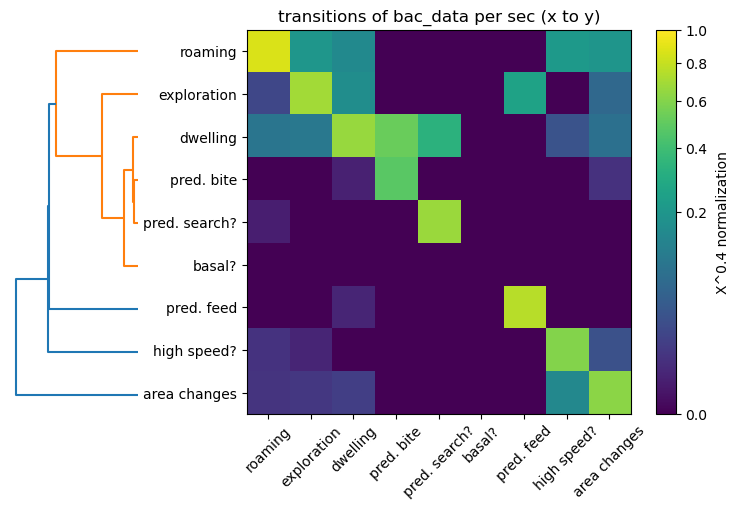

In [209]:
fig = plt.figure()
axs1 = fig.add_axes([0, .895, .2, .805])
axs1.axis('off')
dn = dendrogram(Z, orientation='left',ax= axs1)
axs2 = fig.add_axes([0.33, .9, .8, .8])
im = axs2.imshow(fr_transition_clust,norm=colors.PowerNorm(.4,vmax=1))#vmin=0,vmax=.2)#
axs2.set_xticks(range(len(cluster_group)-1))
axs2.set_xticklabels([cluster_group[k] for k in ordering], rotation=45,ha="center")
axs2.set_yticks(range(len(cluster_group)-1))
axs2.set_yticklabels([cluster_group[k] for k in ordering])
cbar = axs2.figure.colorbar(im, ax=axs2)
cbar.ax.set_ylabel("X^0.4 normalization", rotation=90, labelpad= 6)
axs2.set_title(f"transitions of {data_str} per sec (x to y)")
plt.savefig(os.path.join(out_predicted, os.path.basename(outpath)+'_batch_transitheatmap_clust.pdf'),bbox_inches = "tight")
plt.show()

In [191]:
fr_trans_norm

,0,1,2,3,4,5,6,7,8
0,0.75,0.00,0.000000,0.0,0.003497,0.000000,0.000000,0.000000,0.000000
1,0.00,0.48,0.000000,0.0,0.002607,0.007576,0.000000,0.000000,0.000000
2,0.00,0.00,0.666667,0.0,0.000000,0.000000,0.000000,0.001976,0.000000
3,0.00,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.00,0.52,0.333333,0.0,0.656351,0.082580,0.100569,0.094630,0.033333
5,0.00,0.00,0.000000,0.0,0.014454,0.618612,0.010769,0.008844,0.150000
6,0.25,0.00,0.000000,0.0,0.167750,0.065805,0.685893,0.021064,0.000000
7,0.00,0.00,0.000000,0.0,0.155341,0.195124,0.199367,0.865035,0.216667
8,0.00,0.00,0.000000,0.0,0.000000,0.030303,0.003401,0.008451,0.600000


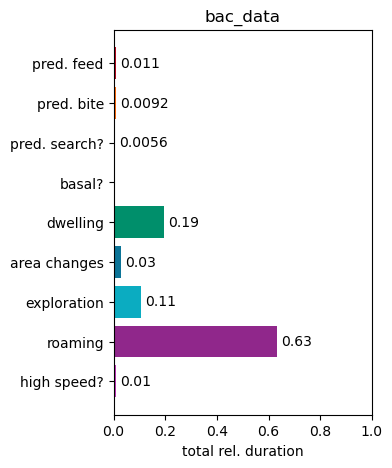

In [40]:
fig, ax = plt.subplots(figsize=(2/.6*1,5))
b = ax.barh(range(len(total_dur_rel)),total_dur_rel, color=list(cluster_color.values())[1:])
ax.set_yticks(range(len(cluster_group)-1))
ax.set_yticklabels([cluster_group[k] for k in cluster_group][1:])
ax.bar_label(b, label_type='edge', fmt='%.2g', padding=3)
ax.invert_yaxis()
plt.xlabel(f"total rel. duration")
plt.title(data_str)
plt.xlim(0,1)
plt.savefig(os.path.join(out_predicted, os.path.basename(outpath)+'_batch_totaldur.pdf'),bbox_inches = "tight")
plt.show()

In [ ]:
    data_describe = data_batch_concat.groupby(y_batch_concat).describe().T.loc[idx[:, ['mean','std','count']], :].sort_index(level=0).T
    dur_describe = pd.DataFrame(dur, columns=['duration']).groupby(transi).describe().T.loc[idx[:, ['mean','std','count']], :].sort_index(level=0).T
    dur_describe['duration','relative'] = pd.DataFrame(dur, columns=['duration']).groupby(transi).apply(lambda cd: cd.sum()/len(y_batch_concat))
    summary = pd.concat([dur_describe, data_describe], axis=1)
    summary.index.name = 'cluster'
    summary = summary.T.reset_index(drop=True).set_index(summary.T.index.map('_'.join)).T
    summary = summary.set_index(summary.index.astype(int))
    summary = summary.reindex([k for k in cluster_label if k != -1])
    summary.to_csv(os.path.join(out_predicted, os.path.basename(outpath)+'_batch_summary.csv'))

    #### Older Version
    
    for i,d in enumerate(data_batch):
        frame = d['prediction'].rolling(30).apply(lambda s: s.mode()[0])[29::30].values.flatten()
        trans_col_,fr_transition_ = crosstab(frame[1:], frame[:-1], levels=([k for k in cluster_label if k != -1],[k for k in cluster_label if k != -1]))
        #fr_transition_ = pd.read_csv() ##################################read transitions.csv should look like normal fr_transition, get trans_col from header
        if i == 0:
            fr_transition = fr_transition_
            trans_col = trans_col_
        if trans_col_ == trans_col:
            fr_transition += fr_transition_
        else:
            print('WARNING')
        #fr_transition/fr_transition.sum(axis=0)
    
    #othersum_axis0 = fr_transition.sum(axis=0)-fr_transition.diagonal()
    #transition_toother = fr_transition/othersum_axis0
    #transition_self = fr_transition.diagonal()/(othersum_axis0+fr_transition.diagonal())
    #np.fill_diagonal(transition_toother, 0)